# 3W dataset's General Presentation

This is a general presentation of the 3W dataset, to the best of its authors' knowledge, the first realistic and public dataset with rare undesirable real events in oil wells that can be readily used as a benchmark dataset for development of machine learning techniques related to inherent difficulties of actual data.

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook presents the 3W dataset in a general way. For this, some tables, graphs, and statistics are presented.

# 2. Imports and Configurations

In [199]:
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
#NUM_PARALLEL_EXEC_UNITS = 6
#config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = NUM_PARALLEL_EXEC_UNITS, 
#         inter_op_parallelism_threads = 1, 
#         allow_soft_placement = True, 
#         device_count = {'CPU': NUM_PARALLEL_EXEC_UNITS })
#session = tf.compat.v1.Session(config=config)
#tf.compat.v1.keras.backend.set_session(session)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from util_3WT import d3w, CustomDataGen

import pickle
import bisect
import sklearn
import sklearn.model_selection
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [81]:
if pathlib.Path('dset.pkl').exists():
  with open('dset.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [3]:
flist0 = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

train_df, test_df, val_df = dset.split(real=False, simul=False, drawn=True, test_size=0.2, val_size=0.1)

Instances Train: 14  Test: 4  Validation: 2


Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/ricardovvargas/3w_dataset/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

# Preprocessing

The following table shows the amount of instances that compose the 3W dataset, by knowledge source (real, simulated and hand-drawn instances) and by instance label.

In [202]:
class kmodel():
    
    def __init__(self, name, layers_list, features, label, categories, batch_size, seq_length, 
                 train_df, val_df, test_df, tmp_path, reset_ts=False, verbose=1, class_bal=False):
        self.features = features
        self.n_features = len(features)
        self.label = label
        self.categories = categories
        self.n_classes = len(*categories)
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.tmp_path = pathlib.Path(tmp_path)
        self.verbose = verbose
        self.class_bal = class_bal
        self.history = None
        self.class_rep_val = None
        self.class_rep_test = None
        self.class_rep_full = None
        self.conf_mat_val = None
        self.conf_mat_test = None
        self.conf_mat_full = None
        
        self.train = CustomDataGen(train_df, self.features, self.label, categories, 
                                   self.batch_size, self.seq_length, self.tmp_path)
        self.val = CustomDataGen(val_df, self.features, self.label, categories, 
                                 self.batch_size, self.seq_length, self.tmp_path)
        self.test = CustomDataGen(test_df, self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        self.full = CustomDataGen(pd.concat([train_df, val_df, test_df], ignore_index=True), 
                                  self.features, self.label, categories, 
                                  self.batch_size, self.seq_length, self.tmp_path)
        
        if reset_ts:
            self.full.reset_ts()

        #print(self.train.__getitem__(0))
        
        input = tf.keras.Input(shape=(self.seq_length, 2*self.n_features), name='input')
        
        for i, layer in enumerate(layers_list):
            config = layer.get_config()
            cloned_layer = type(layer).from_config(config)
            if i == 0:
                output = cloned_layer(input)
            else:
                output = cloned_layer(output)
        
        self.model = tf.keras.Model(input, output, name=name)
        
        for layer in self.model.layers:
            print(self.model.name, layer.name, layer.output_shape)
        print('\n')
        
        if self.verbose > 0:
            print(self.model.summary())
        
        return
    
    
    
    def compile_and_fit(self, max_epochs=20, patience=3, lr=0.001):

        if self.class_bal:
            y_real = self.train.get_y()
            d = dict(zip(np.unique(y_real), compute_class_weight('balanced', classes=np.unique(y_real), y=y_real)))
            w = dict()
            for i, j in enumerate(categories[0]):
                if j in d.keys():
                    w[i] = d[j]
                else:
                    w[i] = 1.0
        else:
            w = None

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_score',
                                                        patience=patience,
                                                        mode='max')

        checkpoint_filepath = self.tmp_path.joinpath('checkpoint')
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_f1_score',
            mode='max',
            save_best_only=True)

        f1_score = tfa.metrics.F1Score(num_classes=self.n_classes, average='micro', threshold=0.5)

        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                           metrics=[tf.keras.metrics.CategoricalAccuracy(), 
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall(),
                                    f1_score])

        self.history = self.model.fit(self.train, epochs=max_epochs,
                                      validation_data=self.val, class_weight=w,
                                      callbacks=[early_stopping, model_checkpoint_callback])

        self.model.load_weights(checkpoint_filepath)
       
        self.class_rep_val, self.conf_mat_val = self.class_rep(self.val)
        
        self.class_rep_test, self.conf_mat_test = self.class_rep(self.test)

        self.class_rep_full, self.conf_mat_full = self.class_rep(self.full)

        if self.verbose > 0:
            self.plot_fithist('f1_score')
            
            self.print_class_rep(self.class_rep_val, 'Val Classification Report')
            self.plot_confusion_matrix(self.conf_mat_val, title='Confusion Matrix Val')
            
            self.print_class_rep(self.class_rep_test, 'Test Classification Report')
            self.plot_confusion_matrix(self.conf_mat_test, title='Confusion Matrix Test')

            self.print_class_rep(self.class_rep_full, 'All Data Classification Report')
            self.plot_confusion_matrix(self.conf_mat_full, title='Confusion Matrix Full')

        return

    # Plot training loss & metric 
    def plot_fithist(self, met):
        N = len(self.history.history['loss'])
        plt.style.use("ggplot")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        fig.suptitle('Training Loss & '+met)

        ax1.plot(np.arange(0, N), self.history.history[met], label="train")
        ax1.plot(np.arange(0, N), self.history.history["val_"+met], label="val")
        ax1.set_title(met)
        ax1.set_xlabel("Epoch #")
        ax1.xaxis.get_major_locator().set_params(integer=True)
        ax1.set_ylabel(met)
        ax1.legend(loc="lower right")

        ax2.plot(np.arange(0, N), self.history.history["loss"], label="train")
        ax2.plot(np.arange(0, N), self.history.history["val_loss"], label="val")
        ax2.set_title("Loss")
        ax2.set_xlabel("Epoch #")
        ax2.xaxis.get_major_locator().set_params(integer=True)
        ax2.set_ylabel("Loss")
        ax2.legend(loc="upper right")

        plt.show()
        return
        
    def save(self):
        filename = self.model.name + '_' +\
            'batch_size_' + str(self.batch_size) + '-' +\
            'seq_length_' + str(self.seq_length) + '-' +\
            str(np.datetime64('now')) + '.h5'
        filename = filename.replace(':', '_')
        self.model.save(filename)
        print('model saved in ' + filename)
        return
    
    def class_rep(self, dset):

        pred = self.model.predict(dset)

        y_pred = [self.categories[0][i] for i in np.argmax(pred, axis=1)]
        y_real = dset.get_y()

        return classification_report(y_real, y_pred, zero_division=0, output_dict=True),\
                                             confusion_matrix(y_real, y_pred, labels=self.categories[0])
    
    def print_class_rep(self, data_dict, title):
        # extracted from: https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/metrics/_classification.py#L1825
        """Build a text report showing the main classification metrics.
        Read more in the :ref:`User Guide <classification_report>`.
        Parameters
        ----------
        report : string
            Text summary of the precision, recall, F1 score for each class.
            Dictionary returned if output_dict is True. Dictionary has the
            following structure::
                {'label 1': {'precision':0.5,
                             'recall':1.0,
                             'f1-score':0.67,
                             'support':1},
                 'label 2': { ... },
                  ...
                }
            The reported averages include macro average (averaging the unweighted
            mean per label), weighted average (averaging the support-weighted mean
            per label), and sample average (only for multilabel classification).
            Micro average (averaging the total true positives, false negatives and
            false positives) is only shown for multi-label or multi-class
            with a subset of classes, because it corresponds to accuracy otherwise.
            See also :func:`precision_recall_fscore_support` for more details
            on averages.
            Note that in binary classification, recall of the positive class
            is also known as "sensitivity"; recall of the negative class is
            "specificity".
        """

        non_label_keys = ["accuracy", "macro avg", "weighted avg"]
        y_type = "binary"
        digits = 2

        target_names = [
            "%s" % key for key in data_dict.keys() if key not in non_label_keys
        ]

        # labelled micro average
        micro_is_accuracy = (y_type == "multiclass" or y_type == "binary")

        headers = ["precision", "recall", "f1-score", "support"]
        p = [data_dict[l][headers[0]] for l in target_names]
        r = [data_dict[l][headers[1]] for l in target_names]
        f1 = [data_dict[l][headers[2]] for l in target_names]
        s = [data_dict[l][headers[3]] for l in target_names]

        rows = zip(target_names, p, r, f1, s)

        if y_type.startswith("multilabel"):
            average_options = ("micro", "macro", "weighted", "samples")
        else:
            average_options = ("micro", "macro", "weighted")

        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

        # compute all applicable averages
        for average in average_options:
            if average.startswith("micro") and micro_is_accuracy:
                line_heading = "accuracy"
            else:
                line_heading = average + " avg"

            if line_heading == "accuracy":
                avg = [data_dict[line_heading], sum(s)]
                row_fmt_accuracy = "{:>{width}s} " + \
                        " {:>9.{digits}}" * 2 + " {:>9.{digits}f}" + \
                        " {:>9}\n"
                report += row_fmt_accuracy.format(line_heading, "", "",
                                                  *avg, width=width,
                                                  digits=digits)
            else:
                avg = list(data_dict[line_heading].values())
                report += row_fmt.format(line_heading, *avg,
                                         width=width, digits=digits)
        print(title)
        print(report)
        
        return

    def plot_confusion_matrix(self, cm, title='Confusion Matrix'):
        con = np.zeros((self.n_classes, self.n_classes))
        for x in range(self.n_classes):
            for y in range(self.n_classes):
                if np.sum(cm[x,:]) > 0:
                    con[x,y] = cm[x,y]/np.sum(cm[x,:])

        plt.figure(figsize=(10,6))
        sns.set(font_scale=0.75) # for label size
        ax = sns.heatmap(con, annot=True,fmt='.3f', cmap='Blues',xticklabels= self.categories[0] , 
                         yticklabels= self.categories[0], cbar=False)
        plt.tight_layout()
        ax.set_xlabel('Predicted', fontsize=16)
        ax.set_ylabel('Real', fontsize=16)
        ax.set_title(title, fontsize=18)
        plt.show()

In [18]:
class param_fit():
    def __init__(self, name, layers_list, features, label, categories, batch_sizes, seq_lengths, learning_rates, 
                 train_df, test_df, tmp_path):
        self.name = name 
        self.layers_list = layers_list
        self.features = features
        self.label = label
        self.categories = categories
        self.batch_sizes = batch_sizes
        self.seq_lengths = seq_lengths
        self.learning_rates = learning_rates
        self.train_df = train_df
        self.test_df = test_df
        self.tmp_path = tmp_path
        self.report = dict()
        return
    
    def fit(self, n_splits=5, max_epochs=50, patience=3):
        kf = sklearn.model_selection.StratifiedKFold(n_splits=n_splits)
        
        self.report['batch_size'] = []
        self.report['seq_length'] = []
        self.report['learning_rate'] = []
        self.report['cv_n'] = []
        self.report['class_rep_val'] = []
        self.report['class_rep_test'] = []
        for batch_size in self.batch_sizes:
            breset = True
            for seq_length in self.seq_lengths:
                breset = True
                for learning_rate in self.learning_rates:
                    for i, (train_index, val_index) in enumerate(kf.split(self.train_df, self.train_df['label'])):
                        print('\n', i, batch_size, seq_length, learning_rate,
                              len(train_index), len(val_index), '\n')
                        model = kmodel(self.name, self.layers_list, self.features, self.label, self.categories, 
                                   batch_size, seq_length, 
                                   self.train_df.iloc[train_index].reset_index(drop=True), 
                                   self.train_df.iloc[val_index].reset_index(drop=True), 
                                   self.test_df, 
                                   'D:/datatmp', reset_ts=breset, verbose=0)
                        model.compile_and_fit(max_epochs=max_epochs, patience=patience, lr=learning_rate)
                        breset = False
                        self.report['batch_size'].append(batch_size)
                        self.report['seq_length'].append(seq_length)
                        self.report['learning_rate'].append(learning_rate)
                        self.report['cv_n'].append(i)
                        self.report['class_rep_val'].append(model.class_rep_val)
                        self.report['class_rep_test'].append(model.class_rep_test)
                        
        
        rep_df = pd.DataFrame(self.report)
        rep_df['val_accuracy'] = rep_df.class_rep_val.apply(pd.Series)['accuracy']
        rep_df['val_precision'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['precision']
        rep_df['val_recall'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['recall']
        rep_df['val_f1_score'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['f1-score']
        rep_df.drop(['class_rep_val', 'class_rep_test'], axis=1, inplace=True)
        
        fdict = {'val_accuracy': ['mean', 'std'], 'val_precision': ['mean', 'std'],
                 'val_recall': ['mean', 'std'], 'val_f1_score': ['mean', 'std']}
        display(rep_df.groupby(['batch_size', 'seq_length', 'learning_rate']).agg(fdict))        
        
        filename = self.name + '_report_' +\
            str(np.datetime64('now')) + '.pkl'
        filename = filename.replace(':', '_')

        with open(filename, 'wb') as f:
            pickle.dump(self.report, f)



In [27]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0)

tf.keras.backend.clear_session()
tf.compat.v1.reset_default_graph()

linear_layers = [tf.keras.layers.Flatten(name='linear_flat'),
                 tf.keras.layers.LayerNormalization(name='linear_norm'),
                 tf.keras.layers.Dense(units=17, activation='sigmoid', name='linear_dense')]

linear_param_fit = param_fit('linear_param_fit', linear_layers, flist0, 'class', categories, 
                             [32, 64], [15, 30], [0.0001, 0.001], 
                             train_df, test_df, 'D:/datatmp')
linear_param_fit.fit(n_splits=5, max_epochs=50)


 0 32 15 0.0001 11 3 

linear_param_fit input [(None, 15, 16)]
linear_param_fit linear_flat (None, 240)
linear_param_fit linear_norm (None, 240)
linear_param_fit linear_dense (None, 17)


Epoch 1/50
786/786 [==============================] - 55s 69ms/step - loss: 2.6799 - categorical_accuracy: 0.2628 - precision: 0.0848 - recall: 0.6901 - f1_score: 0.1511 - val_loss: 2.0900 - val_categorical_accuracy: 0.4505 - val_precision: 0.1039 - val_recall: 0.7916 - val_f1_score: 0.1837
Epoch 2/50
786/786 [==============================] - 47s 60ms/step - loss: 1.7104 - categorical_accuracy: 0.5363 - precision: 0.1326 - recall: 0.8762 - f1_score: 0.2304 - val_loss: 1.3665 - val_categorical_accuracy: 0.6382 - val_precision: 0.1648 - val_recall: 0.9241 - val_f1_score: 0.2798
Epoch 3/50
786/786 [==============================] - 47s 60ms/step - loss: 1.1953 - categorical_accuracy: 0.6404 - precision: 0.2100 - recall: 0.9478 - f1_score: 0.3439 - val_loss: 0.8685 - val_categorical_accuracy: 0.7540 - v

786/786 [==============================] - 43s 55ms/step - loss: 0.5056 - categorical_accuracy: 0.7994 - precision: 0.3544 - recall: 0.9997 - f1_score: 0.5232 - val_loss: 0.3790 - val_categorical_accuracy: 0.8883 - val_precision: 0.3581 - val_recall: 1.0000 - val_f1_score: 0.5274

 1 32 15 0.0001 11 3 

linear_param_fit input [(None, 15, 16)]
linear_param_fit linear_flat (None, 240)
linear_param_fit linear_norm (None, 240)
linear_param_fit linear_dense (None, 17)


Epoch 1/50
823/823 [==============================] - 45s 54ms/step - loss: 3.0095 - categorical_accuracy: 0.2087 - precision_1: 0.0757 - recall_1: 0.6167 - f1_score: 0.1348 - val_loss: 2.4009 - val_categorical_accuracy: 0.3404 - val_precision_1: 0.0905 - val_recall_1: 0.6843 - val_f1_score: 0.1598
Epoch 2/50
823/823 [==============================] - 44s 54ms/step - loss: 1.9081 - categorical_accuracy: 0.4621 - precision_1: 0.1262 - recall_1: 0.8527 - f1_score: 0.2199 - val_loss: 1.4068 - val_categorical_accuracy: 0.6159 - 

Epoch 27/50
823/823 [==============================] - 43s 53ms/step - loss: 0.5318 - categorical_accuracy: 0.7897 - precision_1: 0.3522 - recall_1: 0.9997 - f1_score: 0.5209 - val_loss: 0.3838 - val_categorical_accuracy: 0.9072 - val_precision_1: 0.3346 - val_recall_1: 0.9997 - val_f1_score: 0.5014
Epoch 28/50
823/823 [==============================] - 44s 53ms/step - loss: 0.5299 - categorical_accuracy: 0.7968 - precision_1: 0.3517 - recall_1: 0.9997 - f1_score: 0.5203 - val_loss: 0.3830 - val_categorical_accuracy: 0.9078 - val_precision_1: 0.3377 - val_recall_1: 0.9997 - val_f1_score: 0.5049
Epoch 29/50
823/823 [==============================] - 44s 54ms/step - loss: 0.5291 - categorical_accuracy: 0.7986 - precision_1: 0.3531 - recall_1: 0.9997 - f1_score: 0.5218 - val_loss: 0.3954 - val_categorical_accuracy: 0.8943 - val_precision_1: 0.3378 - val_recall_1: 0.9997 - val_f1_score: 0.5050
Epoch 30/50
823/823 [==============================] - 43s 53ms/step - loss: 0.5265 - categorical

Epoch 4/50
1033/1033 [==============================] - 44s 42ms/step - loss: 0.5718 - categorical_accuracy: 0.8365 - precision_2: 0.3684 - recall_2: 0.9877 - f1_score: 0.5367 - val_loss: 2.0430 - val_categorical_accuracy: 0.3437 - val_precision_2: 0.3137 - val_recall_2: 0.9324 - val_f1_score: 0.4695
Epoch 5/50
1033/1033 [==============================] - 45s 43ms/step - loss: 0.5068 - categorical_accuracy: 0.8528 - precision_2: 0.3695 - recall_2: 0.9945 - f1_score: 0.5388 - val_loss: 1.9109 - val_categorical_accuracy: 0.3545 - val_precision_2: 0.3301 - val_recall_2: 0.9656 - val_f1_score: 0.4920
Epoch 6/50
1033/1033 [==============================] - 43s 42ms/step - loss: 0.4731 - categorical_accuracy: 0.8590 - precision_2: 0.3601 - recall_2: 0.9968 - f1_score: 0.5291 - val_loss: 1.8142 - val_categorical_accuracy: 0.3513 - val_precision_2: 0.3427 - val_recall_2: 0.9816 - val_f1_score: 0.5080
Epoch 7/50
1033/1033 [==============================] - 45s 44ms/step - loss: 0.4488 - categor

977/977 [==============================] - 44s 45ms/step - loss: 0.7924 - categorical_accuracy: 0.7650 - precision_3: 0.2560 - recall_3: 0.9874 - f1_score: 0.4065 - val_loss: 0.9772 - val_categorical_accuracy: 0.6805 - val_precision_3: 0.2961 - val_recall_3: 0.9866 - val_f1_score: 0.4556
Epoch 4/50
977/977 [==============================] - 44s 45ms/step - loss: 0.6375 - categorical_accuracy: 0.7924 - precision_3: 0.3113 - recall_3: 0.9934 - f1_score: 0.4740 - val_loss: 0.8928 - val_categorical_accuracy: 0.6777 - val_precision_3: 0.3192 - val_recall_3: 0.9929 - val_f1_score: 0.4831
Epoch 5/50
977/977 [==============================] - 44s 45ms/step - loss: 0.5738 - categorical_accuracy: 0.8008 - precision_3: 0.3282 - recall_3: 0.9971 - f1_score: 0.4939 - val_loss: 0.8450 - val_categorical_accuracy: 0.6760 - val_precision_3: 0.3235 - val_recall_3: 0.9949 - val_f1_score: 0.4883
Epoch 6/50
977/977 [==============================] - 44s 45ms/step - loss: 0.5352 - categorical_accuracy: 0.81

977/977 [==============================] - 44s 45ms/step - loss: 0.4133 - categorical_accuracy: 0.8518 - precision_3: 0.3753 - recall_3: 0.9999 - f1_score: 0.5457 - val_loss: 0.7474 - val_categorical_accuracy: 0.7264 - val_precision_3: 0.3537 - val_recall_3: 0.9976 - val_f1_score: 0.5222
Epoch 31/50
977/977 [==============================] - 44s 45ms/step - loss: 0.4114 - categorical_accuracy: 0.8550 - precision_3: 0.3759 - recall_3: 1.0000 - f1_score: 0.5464 - val_loss: 0.7331 - val_categorical_accuracy: 0.7208 - val_precision_3: 0.3533 - val_recall_3: 0.9979 - val_f1_score: 0.5218
Epoch 32/50
977/977 [==============================] - 44s 45ms/step - loss: 0.4094 - categorical_accuracy: 0.8506 - precision_3: 0.3766 - recall_3: 1.0000 - f1_score: 0.5472 - val_loss: 0.7407 - val_categorical_accuracy: 0.7313 - val_precision_3: 0.3535 - val_recall_3: 0.9978 - val_f1_score: 0.5221
Epoch 33/50
977/977 [==============================] - 44s 45ms/step - loss: 0.4109 - categorical_accuracy: 0

Epoch 15/50
1145/1145 [==============================] - 44s 39ms/step - loss: 0.4348 - categorical_accuracy: 0.8530 - precision_4: 0.3674 - recall_4: 0.9982 - f1_score: 0.5372 - val_loss: 1.7320 - val_categorical_accuracy: 0.4551 - val_precision_4: 0.3345 - val_recall_4: 0.9172 - val_f1_score: 0.4902
Epoch 16/50
1145/1145 [==============================] - 44s 38ms/step - loss: 0.4317 - categorical_accuracy: 0.8563 - precision_4: 0.3692 - recall_4: 0.9982 - f1_score: 0.5391 - val_loss: 1.7984 - val_categorical_accuracy: 0.4551 - val_precision_4: 0.3350 - val_recall_4: 0.9165 - val_f1_score: 0.4906
Epoch 17/50
1145/1145 [==============================] - 44s 38ms/step - loss: 0.4272 - categorical_accuracy: 0.8557 - precision_4: 0.3704 - recall_4: 0.9982 - f1_score: 0.5403 - val_loss: 1.7909 - val_categorical_accuracy: 0.4529 - val_precision_4: 0.3360 - val_recall_4: 0.9165 - val_f1_score: 0.4917
Epoch 18/50
1145/1145 [==============================] - 44s 38ms/step - loss: 0.4243 - cat

786/786 [==============================] - 45s 57ms/step - loss: 0.5507 - categorical_accuracy: 0.7765 - precision_5: 0.3539 - recall_5: 0.9997 - f1_score: 0.5228 - val_loss: 0.3584 - val_categorical_accuracy: 0.8847 - val_precision_5: 0.3726 - val_recall_5: 1.0000 - val_f1_score: 0.5429
Epoch 6/50
786/786 [==============================] - 43s 55ms/step - loss: 0.5428 - categorical_accuracy: 0.7846 - precision_5: 0.3581 - recall_5: 0.9998 - f1_score: 0.5273 - val_loss: 0.3756 - val_categorical_accuracy: 0.8668 - val_precision_5: 0.3669 - val_recall_5: 1.0000 - val_f1_score: 0.5368
Epoch 7/50
786/786 [==============================] - 43s 55ms/step - loss: 0.5336 - categorical_accuracy: 0.7914 - precision_5: 0.3611 - recall_5: 0.9998 - f1_score: 0.5306 - val_loss: 0.3547 - val_categorical_accuracy: 0.9023 - val_precision_5: 0.3584 - val_recall_5: 1.0000 - val_f1_score: 0.5277
Epoch 8/50
786/786 [==============================] - 43s 55ms/step - loss: 0.5305 - categorical_accuracy: 0.78

977/977 [==============================] - 44s 45ms/step - loss: 0.4637 - categorical_accuracy: 0.8396 - precision_8: 0.3760 - recall_8: 0.9997 - f1_score: 0.5464 - val_loss: 0.7502 - val_categorical_accuracy: 0.7279 - val_precision_8: 0.3555 - val_recall_8: 0.9979 - val_f1_score: 0.5243
Epoch 5/50
977/977 [==============================] - 44s 45ms/step - loss: 0.4496 - categorical_accuracy: 0.8263 - precision_8: 0.3809 - recall_8: 0.9999 - f1_score: 0.5516 - val_loss: 0.7207 - val_categorical_accuracy: 0.7001 - val_precision_8: 0.3524 - val_recall_8: 0.9972 - val_f1_score: 0.5208
Epoch 6/50
977/977 [==============================] - 44s 45ms/step - loss: 0.4483 - categorical_accuracy: 0.8375 - precision_8: 0.3871 - recall_8: 0.9998 - f1_score: 0.5581 - val_loss: 0.7170 - val_categorical_accuracy: 0.7700 - val_precision_8: 0.3674 - val_recall_8: 0.9960 - val_f1_score: 0.5368
Epoch 7/50
977/977 [==============================] - 43s 44ms/step - loss: 0.4408 - categorical_accuracy: 0.83

Epoch 6/50
781/781 [==============================] - 53s 68ms/step - loss: 0.6334 - categorical_accuracy: 0.7761 - precision_10: 0.3208 - recall_10: 0.9984 - f1_score: 0.4856 - val_loss: 0.4502 - val_categorical_accuracy: 0.8454 - val_precision_10: 0.3225 - val_recall_10: 1.0000 - val_f1_score: 0.4878
Epoch 7/50
781/781 [==============================] - 53s 68ms/step - loss: 0.6008 - categorical_accuracy: 0.7809 - precision_10: 0.3238 - recall_10: 0.9993 - f1_score: 0.4891 - val_loss: 0.4180 - val_categorical_accuracy: 0.8548 - val_precision_10: 0.3284 - val_recall_10: 1.0000 - val_f1_score: 0.4944
Epoch 8/50
781/781 [==============================] - 53s 68ms/step - loss: 0.5767 - categorical_accuracy: 0.7886 - precision_10: 0.3277 - recall_10: 0.9996 - f1_score: 0.4936 - val_loss: 0.4111 - val_categorical_accuracy: 0.8624 - val_precision_10: 0.3283 - val_recall_10: 1.0000 - val_f1_score: 0.4943
Epoch 9/50
781/781 [==============================] - 53s 68ms/step - loss: 0.5594 - cat

Epoch 33/50
781/781 [==============================] - 54s 69ms/step - loss: 0.4114 - categorical_accuracy: 0.8307 - precision_10: 0.3536 - recall_10: 1.0000 - f1_score: 0.5224 - val_loss: 0.3307 - val_categorical_accuracy: 0.9032 - val_precision_10: 0.3596 - val_recall_10: 1.0000 - val_f1_score: 0.5290
Epoch 34/50
781/781 [==============================] - 53s 68ms/step - loss: 0.4062 - categorical_accuracy: 0.8433 - precision_10: 0.3546 - recall_10: 1.0000 - f1_score: 0.5236 - val_loss: 0.3248 - val_categorical_accuracy: 0.8889 - val_precision_10: 0.3611 - val_recall_10: 1.0000 - val_f1_score: 0.5306
Epoch 35/50
781/781 [==============================] - 53s 68ms/step - loss: 0.4069 - categorical_accuracy: 0.8327 - precision_10: 0.3536 - recall_10: 1.0000 - f1_score: 0.5225 - val_loss: 0.3328 - val_categorical_accuracy: 0.8871 - val_precision_10: 0.3663 - val_recall_10: 1.0000 - val_f1_score: 0.5362
Epoch 36/50
781/781 [==============================] - 53s 68ms/step - loss: 0.4024 -

Epoch 10/50
1029/1029 [==============================] - 54s 52ms/step - loss: 0.3272 - categorical_accuracy: 0.9011 - precision_12: 0.3411 - recall_12: 0.9983 - f1_score: 0.5085 - val_loss: 1.4587 - val_categorical_accuracy: 0.4457 - val_precision_12: 0.3490 - val_recall_12: 0.9933 - val_f1_score: 0.5165
Epoch 11/50
1029/1029 [==============================] - 54s 53ms/step - loss: 0.3185 - categorical_accuracy: 0.9051 - precision_12: 0.3444 - recall_12: 0.9992 - f1_score: 0.5123 - val_loss: 1.4346 - val_categorical_accuracy: 0.4429 - val_precision_12: 0.3518 - val_recall_12: 0.9954 - val_f1_score: 0.5198
Epoch 12/50
1029/1029 [==============================] - 54s 53ms/step - loss: 0.3104 - categorical_accuracy: 0.9085 - precision_12: 0.3428 - recall_12: 0.9991 - f1_score: 0.5104 - val_loss: 1.3993 - val_categorical_accuracy: 0.4287 - val_precision_12: 0.3542 - val_recall_12: 0.9972 - val_f1_score: 0.5227
Epoch 13/50
1029/1029 [==============================] - 54s 53ms/step - loss: 

973/973 [==============================] - 53s 55ms/step - loss: 0.3859 - categorical_accuracy: 0.8603 - precision_13: 0.3666 - recall_13: 0.9999 - f1_score: 0.5365 - val_loss: 0.6859 - val_categorical_accuracy: 0.7416 - val_precision_13: 0.3492 - val_recall_13: 0.9979 - val_f1_score: 0.5174
Epoch 16/50
973/973 [==============================] - 54s 56ms/step - loss: 0.3816 - categorical_accuracy: 0.8583 - precision_13: 0.3674 - recall_13: 1.0000 - f1_score: 0.5373 - val_loss: 0.6793 - val_categorical_accuracy: 0.7397 - val_precision_13: 0.3532 - val_recall_13: 0.9987 - val_f1_score: 0.5218
Epoch 17/50
973/973 [==============================] - 54s 55ms/step - loss: 0.3789 - categorical_accuracy: 0.8586 - precision_13: 0.3682 - recall_13: 1.0000 - f1_score: 0.5382 - val_loss: 0.6988 - val_categorical_accuracy: 0.7464 - val_precision_13: 0.3554 - val_recall_13: 0.9966 - val_f1_score: 0.5239
Epoch 18/50
973/973 [==============================] - 53s 55ms/step - loss: 0.3771 - categorical

1142/1142 [==============================] - 54s 48ms/step - loss: 0.3844 - categorical_accuracy: 0.8686 - precision_14: 0.3680 - recall_14: 0.9997 - f1_score: 0.5380 - val_loss: 1.7351 - val_categorical_accuracy: 0.4367 - val_precision_14: 0.3451 - val_recall_14: 1.0000 - val_f1_score: 0.5132
Epoch 13/50
1142/1142 [==============================] - 55s 48ms/step - loss: 0.3781 - categorical_accuracy: 0.8686 - precision_14: 0.3684 - recall_14: 0.9998 - f1_score: 0.5384 - val_loss: 1.7932 - val_categorical_accuracy: 0.4331 - val_precision_14: 0.3472 - val_recall_14: 1.0000 - val_f1_score: 0.5155
Epoch 14/50
1142/1142 [==============================] - 55s 48ms/step - loss: 0.3720 - categorical_accuracy: 0.8692 - precision_14: 0.3688 - recall_14: 0.9998 - f1_score: 0.5388 - val_loss: 1.8169 - val_categorical_accuracy: 0.4353 - val_precision_14: 0.3478 - val_recall_14: 1.0000 - val_f1_score: 0.5161
Epoch 15/50
1142/1142 [==============================] - 55s 49ms/step - loss: 0.3691 - cat

Epoch 7/50
819/819 [==============================] - 53s 65ms/step - loss: 0.4587 - categorical_accuracy: 0.8222 - precision_16: 0.3700 - recall_16: 0.9998 - f1_score: 0.5401 - val_loss: 0.5334 - val_categorical_accuracy: 0.7548 - val_precision_16: 0.3635 - val_recall_16: 1.0000 - val_f1_score: 0.5332
Epoch 8/50
819/819 [==============================] - 53s 64ms/step - loss: 0.4532 - categorical_accuracy: 0.8187 - precision_16: 0.3771 - recall_16: 1.0000 - f1_score: 0.5477 - val_loss: 0.2938 - val_categorical_accuracy: 0.9317 - val_precision_16: 0.3562 - val_recall_16: 1.0000 - val_f1_score: 0.5253
Epoch 9/50
819/819 [==============================] - 53s 65ms/step - loss: 0.4403 - categorical_accuracy: 0.8313 - precision_16: 0.3774 - recall_16: 1.0000 - f1_score: 0.5480 - val_loss: 0.2175 - val_categorical_accuracy: 0.9434 - val_precision_16: 0.3680 - val_recall_16: 1.0000 - val_f1_score: 0.5380
Epoch 10/50
819/819 [==============================] - 53s 65ms/step - loss: 0.4236 - ca

Epoch 4/50
973/973 [==============================] - 56s 57ms/step - loss: 0.4244 - categorical_accuracy: 0.8421 - precision_18: 0.3754 - recall_18: 1.0000 - f1_score: 0.5459 - val_loss: 0.6381 - val_categorical_accuracy: 0.7736 - val_precision_18: 0.3576 - val_recall_18: 0.9966 - val_f1_score: 0.5263
Epoch 5/50
973/973 [==============================] - 54s 56ms/step - loss: 0.3993 - categorical_accuracy: 0.8466 - precision_18: 0.3848 - recall_18: 1.0000 - f1_score: 0.5558 - val_loss: 0.7755 - val_categorical_accuracy: 0.7020 - val_precision_18: 0.3683 - val_recall_18: 0.9930 - val_f1_score: 0.5373
Epoch 6/50
973/973 [==============================] - 55s 56ms/step - loss: 0.3853 - categorical_accuracy: 0.8585 - precision_18: 0.3922 - recall_18: 1.0000 - f1_score: 0.5634 - val_loss: 0.7472 - val_categorical_accuracy: 0.7345 - val_precision_18: 0.3669 - val_recall_18: 0.9953 - val_f1_score: 0.5362
Epoch 7/50
973/973 [==============================] - 54s 55ms/step - loss: 0.3828 - cat

Epoch 9/50
396/396 [==============================] - 15s 38ms/step - loss: 0.7730 - categorical_accuracy: 0.7471 - precision_20: 0.2980 - recall_20: 0.9944 - f1_score: 0.4586 - val_loss: 0.5702 - val_categorical_accuracy: 0.8292 - val_precision_20: 0.2979 - val_recall_20: 0.9995 - val_f1_score: 0.4590
Epoch 10/50
396/396 [==============================] - 15s 38ms/step - loss: 0.7303 - categorical_accuracy: 0.7477 - precision_20: 0.3076 - recall_20: 0.9964 - f1_score: 0.4701 - val_loss: 0.5327 - val_categorical_accuracy: 0.8369 - val_precision_20: 0.3062 - val_recall_20: 0.9997 - val_f1_score: 0.4688
Epoch 11/50
396/396 [==============================] - 15s 38ms/step - loss: 0.6994 - categorical_accuracy: 0.7617 - precision_20: 0.3126 - recall_20: 0.9974 - f1_score: 0.4760 - val_loss: 0.5058 - val_categorical_accuracy: 0.8406 - val_precision_20: 0.3099 - val_recall_20: 0.9999 - val_f1_score: 0.4731
Epoch 12/50
396/396 [==============================] - 15s 37ms/step - loss: 0.6770 - 

Epoch 36/50
396/396 [==============================] - 14s 35ms/step - loss: 0.5314 - categorical_accuracy: 0.7973 - precision_20: 0.3371 - recall_20: 0.9996 - f1_score: 0.5042 - val_loss: 0.4053 - val_categorical_accuracy: 0.8594 - val_precision_20: 0.3315 - val_recall_20: 1.0000 - val_f1_score: 0.4979
Epoch 37/50
396/396 [==============================] - 14s 36ms/step - loss: 0.5297 - categorical_accuracy: 0.7948 - precision_20: 0.3362 - recall_20: 0.9996 - f1_score: 0.5032 - val_loss: 0.4119 - val_categorical_accuracy: 0.8478 - val_precision_20: 0.3343 - val_recall_20: 1.0000 - val_f1_score: 0.5010
Epoch 38/50
396/396 [==============================] - 15s 37ms/step - loss: 0.5295 - categorical_accuracy: 0.7895 - precision_20: 0.3376 - recall_20: 0.9996 - f1_score: 0.5047 - val_loss: 0.4043 - val_categorical_accuracy: 0.8679 - val_precision_20: 0.3335 - val_recall_20: 1.0000 - val_f1_score: 0.5002
Epoch 39/50
396/396 [==============================] - 15s 38ms/step - loss: 0.5272 -

415/415 [==============================] - 16s 38ms/step - loss: 0.6535 - categorical_accuracy: 0.7357 - precision_21: 0.3287 - recall_21: 0.9985 - f1_score: 0.4946 - val_loss: 0.4954 - val_categorical_accuracy: 0.8142 - val_precision_21: 0.3176 - val_recall_21: 0.9998 - val_f1_score: 0.4821
Epoch 15/50
415/415 [==============================] - 15s 36ms/step - loss: 0.6395 - categorical_accuracy: 0.7424 - precision_21: 0.3296 - recall_21: 0.9987 - f1_score: 0.4956 - val_loss: 0.4847 - val_categorical_accuracy: 0.8322 - val_precision_21: 0.3180 - val_recall_21: 0.9999 - val_f1_score: 0.4825
Epoch 16/50
415/415 [==============================] - 15s 37ms/step - loss: 0.6296 - categorical_accuracy: 0.7436 - precision_21: 0.3316 - recall_21: 0.9987 - f1_score: 0.4979 - val_loss: 0.4699 - val_categorical_accuracy: 0.8523 - val_precision_21: 0.3181 - val_recall_21: 0.9999 - val_f1_score: 0.4826
Epoch 17/50
415/415 [==============================] - 15s 36ms/step - loss: 0.6194 - categorical

Epoch 41/50
415/415 [==============================] - 15s 36ms/step - loss: 0.5392 - categorical_accuracy: 0.7954 - precision_21: 0.3504 - recall_21: 0.9992 - f1_score: 0.5189 - val_loss: 0.3925 - val_categorical_accuracy: 0.9032 - val_precision_21: 0.3300 - val_recall_21: 0.9997 - val_f1_score: 0.4963
Epoch 42/50
415/415 [==============================] - 15s 37ms/step - loss: 0.5387 - categorical_accuracy: 0.7900 - precision_21: 0.3512 - recall_21: 0.9993 - f1_score: 0.5197 - val_loss: 0.3990 - val_categorical_accuracy: 0.8985 - val_precision_21: 0.3303 - val_recall_21: 0.9997 - val_f1_score: 0.4965
Epoch 43/50
415/415 [==============================] - 16s 38ms/step - loss: 0.5379 - categorical_accuracy: 0.7930 - precision_21: 0.3530 - recall_21: 0.9993 - f1_score: 0.5217 - val_loss: 0.3967 - val_categorical_accuracy: 0.9007 - val_precision_21: 0.3311 - val_recall_21: 0.9997 - val_f1_score: 0.4975
Epoch 44/50
415/415 [==============================] - 15s 37ms/step - loss: 0.5357 -

519/519 [==============================] - 16s 30ms/step - loss: 0.4133 - categorical_accuracy: 0.8708 - precision_22: 0.3486 - recall_22: 0.9980 - f1_score: 0.5167 - val_loss: 1.6784 - val_categorical_accuracy: 0.3687 - val_precision_22: 0.3417 - val_recall_22: 0.9832 - val_f1_score: 0.5072
Epoch 18/50
519/519 [==============================] - 15s 29ms/step - loss: 0.4076 - categorical_accuracy: 0.8723 - precision_22: 0.3480 - recall_22: 0.9980 - f1_score: 0.5160 - val_loss: 1.6503 - val_categorical_accuracy: 0.3755 - val_precision_22: 0.3425 - val_recall_22: 0.9846 - val_f1_score: 0.5083
Epoch 19/50
519/519 [==============================] - 15s 30ms/step - loss: 0.4024 - categorical_accuracy: 0.8759 - precision_22: 0.3479 - recall_22: 0.9983 - f1_score: 0.5160 - val_loss: 1.6347 - val_categorical_accuracy: 0.3743 - val_precision_22: 0.3449 - val_recall_22: 0.9858 - val_f1_score: 0.5110
Epoch 20/50
519/519 [==============================] - 15s 29ms/step - loss: 0.3987 - categorical

Epoch 44/50
519/519 [==============================] - 12s 24ms/step - loss: 0.3489 - categorical_accuracy: 0.8874 - precision_22: 0.3566 - recall_22: 0.9995 - f1_score: 0.5257 - val_loss: 1.4824 - val_categorical_accuracy: 0.3855 - val_precision_22: 0.3660 - val_recall_22: 0.9948 - val_f1_score: 0.5351
Epoch 45/50
519/519 [==============================] - 15s 29ms/step - loss: 0.3472 - categorical_accuracy: 0.8882 - precision_22: 0.3568 - recall_22: 0.9995 - f1_score: 0.5259 - val_loss: 1.4767 - val_categorical_accuracy: 0.3909 - val_precision_22: 0.3660 - val_recall_22: 0.9948 - val_f1_score: 0.5351
Epoch 46/50
519/519 [==============================] - 14s 27ms/step - loss: 0.3471 - categorical_accuracy: 0.8883 - precision_22: 0.3558 - recall_22: 0.9995 - f1_score: 0.5248 - val_loss: 1.4492 - val_categorical_accuracy: 0.3935 - val_precision_22: 0.3669 - val_recall_22: 0.9954 - val_f1_score: 0.5362
Epoch 47/50
519/519 [==============================] - 13s 25ms/step - loss: 0.3449 -

Epoch 7/50
575/575 [==============================] - 16s 28ms/step - loss: 0.6367 - categorical_accuracy: 0.7794 - precision_24: 0.3433 - recall_24: 0.9944 - f1_score: 0.5103 - val_loss: 1.5811 - val_categorical_accuracy: 0.4367 - val_precision_24: 0.3022 - val_recall_24: 0.9398 - val_f1_score: 0.4573
Epoch 8/50
575/575 [==============================] - 16s 28ms/step - loss: 0.5964 - categorical_accuracy: 0.7880 - precision_24: 0.3502 - recall_24: 0.9958 - f1_score: 0.5181 - val_loss: 1.5792 - val_categorical_accuracy: 0.4416 - val_precision_24: 0.3097 - val_recall_24: 0.9398 - val_f1_score: 0.4659
Epoch 9/50
575/575 [==============================] - 16s 28ms/step - loss: 0.5707 - categorical_accuracy: 0.8005 - precision_24: 0.3494 - recall_24: 0.9962 - f1_score: 0.5174 - val_loss: 1.5437 - val_categorical_accuracy: 0.4452 - val_precision_24: 0.3190 - val_recall_24: 0.9420 - val_f1_score: 0.4766
Epoch 10/50
575/575 [==============================] - 16s 28ms/step - loss: 0.5511 - ca

Epoch 34/50
575/575 [==============================] - 17s 30ms/step - loss: 0.4327 - categorical_accuracy: 0.8567 - precision_24: 0.3778 - recall_24: 0.9987 - f1_score: 0.5482 - val_loss: 1.8399 - val_categorical_accuracy: 0.4501 - val_precision_24: 0.3581 - val_recall_24: 0.9858 - val_f1_score: 0.5254
Epoch 35/50
575/575 [==============================] - 17s 29ms/step - loss: 0.4321 - categorical_accuracy: 0.8558 - precision_24: 0.3781 - recall_24: 0.9988 - f1_score: 0.5485 - val_loss: 1.8203 - val_categorical_accuracy: 0.4536 - val_precision_24: 0.3589 - val_recall_24: 0.9851 - val_f1_score: 0.5262
Epoch 36/50
575/575 [==============================] - 17s 29ms/step - loss: 0.4286 - categorical_accuracy: 0.8578 - precision_24: 0.3779 - recall_24: 0.9987 - f1_score: 0.5484 - val_loss: 1.8697 - val_categorical_accuracy: 0.4586 - val_precision_24: 0.3605 - val_recall_24: 0.9894 - val_f1_score: 0.5284
Epoch 37/50
575/575 [==============================] - 17s 29ms/step - loss: 0.4291 -

519/519 [==============================] - 16s 30ms/step - loss: 0.4178 - categorical_accuracy: 0.8663 - precision_27: 0.3411 - recall_27: 0.9995 - f1_score: 0.5086 - val_loss: 1.5886 - val_categorical_accuracy: 0.4111 - val_precision_27: 0.3589 - val_recall_27: 0.9982 - val_f1_score: 0.5280
Epoch 5/50
519/519 [==============================] - 15s 30ms/step - loss: 0.3818 - categorical_accuracy: 0.8791 - precision_27: 0.3385 - recall_27: 0.9999 - f1_score: 0.5058 - val_loss: 1.6526 - val_categorical_accuracy: 0.3385 - val_precision_27: 0.3640 - val_recall_27: 0.9998 - val_f1_score: 0.5337
Epoch 6/50
519/519 [==============================] - 15s 29ms/step - loss: 0.3841 - categorical_accuracy: 0.8807 - precision_27: 0.3439 - recall_27: 0.9998 - f1_score: 0.5117 - val_loss: 1.7884 - val_categorical_accuracy: 0.4063 - val_precision_27: 0.3582 - val_recall_27: 0.9984 - val_f1_score: 0.5272
Epoch 7/50
519/519 [==============================] - 15s 29ms/step - loss: 0.3735 - categorical_ac

491/491 [==============================] - 15s 30ms/step - loss: 0.4219 - categorical_accuracy: 0.8504 - precision_28: 0.3983 - recall_28: 1.0000 - f1_score: 0.5697 - val_loss: 0.7470 - val_categorical_accuracy: 0.7586 - val_precision_28: 0.3584 - val_recall_28: 0.9988 - val_f1_score: 0.5275
Epoch 17/50
491/491 [==============================] - 14s 29ms/step - loss: 0.4274 - categorical_accuracy: 0.8408 - precision_28: 0.4010 - recall_28: 1.0000 - f1_score: 0.5724 - val_loss: 0.7369 - val_categorical_accuracy: 0.7242 - val_precision_28: 0.3557 - val_recall_28: 0.9993 - val_f1_score: 0.5247
Epoch 18/50
491/491 [==============================] - 14s 29ms/step - loss: 0.4241 - categorical_accuracy: 0.8417 - precision_28: 0.3966 - recall_28: 1.0000 - f1_score: 0.5680 - val_loss: 0.7581 - val_categorical_accuracy: 0.7282 - val_precision_28: 0.3599 - val_recall_28: 0.9982 - val_f1_score: 0.5290

 4 64 15 0.001 12 2 

linear_param_fit input [(None, 15, 16)]
linear_param_fit linear_flat (None

Epoch 12/50
392/392 [==============================] - 20s 50ms/step - loss: 0.6201 - categorical_accuracy: 0.7744 - precision_30: 0.3281 - recall_30: 0.9987 - f1_score: 0.4940 - val_loss: 0.4315 - val_categorical_accuracy: 0.8638 - val_precision_30: 0.3286 - val_recall_30: 1.0000 - val_f1_score: 0.4946
Epoch 13/50
392/392 [==============================] - 19s 49ms/step - loss: 0.6002 - categorical_accuracy: 0.7768 - precision_30: 0.3317 - recall_30: 0.9991 - f1_score: 0.4980 - val_loss: 0.4327 - val_categorical_accuracy: 0.8594 - val_precision_30: 0.3252 - val_recall_30: 1.0000 - val_f1_score: 0.4908
Epoch 14/50
392/392 [==============================] - 19s 48ms/step - loss: 0.5889 - categorical_accuracy: 0.7868 - precision_30: 0.3323 - recall_30: 0.9992 - f1_score: 0.4987 - val_loss: 0.4226 - val_categorical_accuracy: 0.8528 - val_precision_30: 0.3280 - val_recall_30: 1.0000 - val_f1_score: 0.4940
Epoch 15/50
392/392 [==============================] - 19s 48ms/step - loss: 0.5750 -

411/411 [==============================] - 20s 49ms/step - loss: 0.5837 - categorical_accuracy: 0.7725 - precision_31: 0.3373 - recall_31: 0.9978 - f1_score: 0.5041 - val_loss: 0.4467 - val_categorical_accuracy: 0.8508 - val_precision_31: 0.3259 - val_recall_31: 0.9998 - val_f1_score: 0.4916
Epoch 14/50
411/411 [==============================] - 20s 49ms/step - loss: 0.5737 - categorical_accuracy: 0.7788 - precision_31: 0.3385 - recall_31: 0.9986 - f1_score: 0.5057 - val_loss: 0.4435 - val_categorical_accuracy: 0.8551 - val_precision_31: 0.3264 - val_recall_31: 1.0000 - val_f1_score: 0.4922

 2 64 30 0.0001 11 3 

linear_param_fit input [(None, 30, 16)]
linear_param_fit linear_flat (None, 480)
linear_param_fit linear_norm (None, 480)
linear_param_fit linear_dense (None, 17)


Epoch 1/50
516/516 [==============================] - 21s 40ms/step - loss: 2.5847 - categorical_accuracy: 0.2870 - precision_32: 0.0852 - recall_32: 0.7222 - f1_score: 0.1524 - val_loss: 2.5497 - val_categorical_

516/516 [==============================] - 19s 36ms/step - loss: 0.3196 - categorical_accuracy: 0.9021 - precision_32: 0.3486 - recall_32: 0.9999 - f1_score: 0.5170 - val_loss: 1.4549 - val_categorical_accuracy: 0.4499 - val_precision_32: 0.3546 - val_recall_32: 0.9988 - val_f1_score: 0.5233
Epoch 26/50
516/516 [==============================] - 19s 37ms/step - loss: 0.3172 - categorical_accuracy: 0.9041 - precision_32: 0.3469 - recall_32: 0.9998 - f1_score: 0.5151 - val_loss: 1.4286 - val_categorical_accuracy: 0.4300 - val_precision_32: 0.3559 - val_recall_32: 0.9992 - val_f1_score: 0.5248
Epoch 27/50
516/516 [==============================] - 19s 36ms/step - loss: 0.3148 - categorical_accuracy: 0.9042 - precision_32: 0.3469 - recall_32: 1.0000 - f1_score: 0.5151 - val_loss: 1.4496 - val_categorical_accuracy: 0.4247 - val_precision_32: 0.3596 - val_recall_32: 0.9992 - val_f1_score: 0.5288
Epoch 28/50
516/516 [==============================] - 20s 39ms/step - loss: 0.3130 - categorical

488/488 [==============================] - 19s 39ms/step - loss: 0.4387 - categorical_accuracy: 0.8422 - precision_33: 0.3494 - recall_33: 0.9996 - f1_score: 0.5178 - val_loss: 0.7407 - val_categorical_accuracy: 0.7285 - val_precision_33: 0.3258 - val_recall_33: 0.9962 - val_f1_score: 0.4910
Epoch 15/50
488/488 [==============================] - 19s 40ms/step - loss: 0.4305 - categorical_accuracy: 0.8522 - precision_33: 0.3500 - recall_33: 0.9997 - f1_score: 0.5185 - val_loss: 0.7189 - val_categorical_accuracy: 0.7381 - val_precision_33: 0.3302 - val_recall_33: 0.9969 - val_f1_score: 0.4961
Epoch 16/50
488/488 [==============================] - 19s 38ms/step - loss: 0.4262 - categorical_accuracy: 0.8416 - precision_33: 0.3525 - recall_33: 0.9998 - f1_score: 0.5212 - val_loss: 0.7066 - val_categorical_accuracy: 0.7446 - val_precision_33: 0.3317 - val_recall_33: 0.9972 - val_f1_score: 0.4978
Epoch 17/50
488/488 [==============================] - 19s 39ms/step - loss: 0.4196 - categorical

Epoch 41/50
488/488 [==============================] - 20s 40ms/step - loss: 0.3593 - categorical_accuracy: 0.8681 - precision_33: 0.3771 - recall_33: 1.0000 - f1_score: 0.5477 - val_loss: 0.6591 - val_categorical_accuracy: 0.7396 - val_precision_33: 0.3514 - val_recall_33: 0.9948 - val_f1_score: 0.5194
Epoch 42/50
488/488 [==============================] - 16s 32ms/step - loss: 0.3596 - categorical_accuracy: 0.8702 - precision_33: 0.3746 - recall_33: 1.0000 - f1_score: 0.5451 - val_loss: 0.6631 - val_categorical_accuracy: 0.7436 - val_precision_33: 0.3526 - val_recall_33: 0.9942 - val_f1_score: 0.5206
Epoch 43/50
488/488 [==============================] - 15s 31ms/step - loss: 0.3546 - categorical_accuracy: 0.8623 - precision_33: 0.3767 - recall_33: 1.0000 - f1_score: 0.5472 - val_loss: 0.6496 - val_categorical_accuracy: 0.7564 - val_precision_33: 0.3535 - val_recall_33: 0.9941 - val_f1_score: 0.5216

 4 64 30 0.0001 12 2 

linear_param_fit input [(None, 30, 16)]
linear_param_fit line

573/573 [==============================] - 20s 34ms/step - loss: 0.3932 - categorical_accuracy: 0.8673 - precision_34: 0.3652 - recall_34: 0.9998 - f1_score: 0.5350 - val_loss: 1.6552 - val_categorical_accuracy: 0.4237 - val_precision_34: 0.3450 - val_recall_34: 0.9993 - val_f1_score: 0.5129
Epoch 25/50
573/573 [==============================] - 19s 33ms/step - loss: 0.3902 - categorical_accuracy: 0.8632 - precision_34: 0.3652 - recall_34: 0.9999 - f1_score: 0.5350 - val_loss: 1.6580 - val_categorical_accuracy: 0.4302 - val_precision_34: 0.3465 - val_recall_34: 0.9993 - val_f1_score: 0.5145
Epoch 26/50
573/573 [==============================] - 19s 34ms/step - loss: 0.3887 - categorical_accuracy: 0.8652 - precision_34: 0.3653 - recall_34: 0.9999 - f1_score: 0.5351 - val_loss: 1.6638 - val_categorical_accuracy: 0.4266 - val_precision_34: 0.3479 - val_recall_34: 0.9993 - val_f1_score: 0.5162
Epoch 27/50
573/573 [==============================] - 19s 33ms/step - loss: 0.3832 - categorical

392/392 [==============================] - 19s 48ms/step - loss: 0.4398 - categorical_accuracy: 0.8420 - precision_35: 0.3612 - recall_35: 1.0000 - f1_score: 0.5308 - val_loss: 0.3823 - val_categorical_accuracy: 0.8209 - val_precision_35: 0.3765 - val_recall_35: 1.0000 - val_f1_score: 0.5470

 1 64 30 0.001 11 3 

linear_param_fit input [(None, 30, 16)]
linear_param_fit linear_flat (None, 480)
linear_param_fit linear_norm (None, 480)
linear_param_fit linear_dense (None, 17)


Epoch 1/50
411/411 [==============================] - 22s 51ms/step - loss: 1.3707 - categorical_accuracy: 0.6173 - precision_36: 0.1784 - recall_36: 0.8973 - f1_score: 0.2976 - val_loss: 0.6307 - val_categorical_accuracy: 0.7154 - val_precision_36: 0.3209 - val_recall_36: 0.9997 - val_f1_score: 0.4859
Epoch 2/50
411/411 [==============================] - 20s 48ms/step - loss: 0.6732 - categorical_accuracy: 0.7348 - precision_36: 0.3298 - recall_36: 0.9985 - f1_score: 0.4959 - val_loss: 0.5081 - val_categorical_ac

488/488 [==============================] - 20s 41ms/step - loss: 0.4183 - categorical_accuracy: 0.8488 - precision_38: 0.3868 - recall_38: 1.0000 - f1_score: 0.5579 - val_loss: 0.6601 - val_categorical_accuracy: 0.7489 - val_precision_38: 0.3637 - val_recall_38: 0.9960 - val_f1_score: 0.5328

 4 64 30 0.001 12 2 

linear_param_fit input [(None, 30, 16)]
linear_param_fit linear_flat (None, 480)
linear_param_fit linear_norm (None, 480)
linear_param_fit linear_dense (None, 17)


Epoch 1/50
573/573 [==============================] - 22s 36ms/step - loss: 1.0869 - categorical_accuracy: 0.6949 - precision_39: 0.1989 - recall_39: 0.9411 - f1_score: 0.3283 - val_loss: 1.5352 - val_categorical_accuracy: 0.4902 - val_precision_39: 0.3169 - val_recall_39: 0.9863 - val_f1_score: 0.4797
Epoch 2/50
573/573 [==============================] - 20s 35ms/step - loss: 0.5188 - categorical_accuracy: 0.8216 - precision_39: 0.3521 - recall_39: 0.9986 - f1_score: 0.5206 - val_loss: 1.7748 - val_categorical_ac

val_accuracy           val_precision  \
                                            mean       std          mean   
batch_size seq_length learning_rate                                        
32         15         0.0001            0.665671  0.246860      0.519985   
                      0.0010            0.642290  0.218472      0.547035   
           30         0.0001            0.669884  0.226532      0.548703   
                      0.0010            0.719058  0.179066      0.573321   
64         15         0.0001            0.653144  0.233400      0.543384   
                      0.0010            0.670724  0.212067      0.532407   
           30         0.0001            0.656310  0.210698      0.553063   
                      0.0010            0.733807  0.119837      0.604968   

                                              val_recall            \
                                          std       mean       std   
batch_size seq_length learning_rate                                  
32         15         0.0001         0.158661   0.488396  0.180500   
                      0.0010         0.168279   0.493555  0.196256   
           30         0.0001         0.200893   0.522091  0.179070   
                      0.0010         0.169684   0.574887  0.200914   
64         15         0.0001         0.195565   0.505214  0.186207   
                      0.0010         0.193926   0.504263  0.175315   
           30         0.0001         0.198917   0.515749  0.178059   
                      0.0010         0.163444   0.525607  0.167024   

                                    val_f1_score            
                                            mean       std  
batch_size seq_length learning_rate                         
32         15         0.0001            0.467816  0.167048  
                      0.0010            0.472199  0.181776  
           30         0.0001            0.503464  0.162327  
                      0.0010            0.539743  0.169284  
64         15         0.0001            0.484820  0.161051  
                      0.0010            0.476540  0.162824  
           30         0.0001            0.496960  0.160104  
                      0.0010            0.520603  0.151785

Wall time: 8h 24min 9s


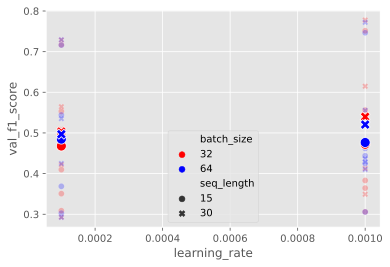

In [88]:
rep_df = pd.DataFrame(linear_param_fit.report)
rep_df['val_accuracy'] = rep_df.class_rep_val.apply(pd.Series)['accuracy']
rep_df['val_precision'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['precision']
rep_df['val_recall'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['recall']
rep_df['val_f1_score'] = rep_df.class_rep_val.apply(pd.Series)['macro avg'].apply(pd.Series)['f1-score']
rep_df.drop(['class_rep_val', 'class_rep_test'], axis=1, inplace=True)

fdict = {'val_accuracy': ['mean', 'std'], 'val_precision': ['mean', 'std'],
         'val_recall': ['mean', 'std'], 'val_f1_score': ['mean', 'std']}
rep_df_stat = rep_df.groupby(['batch_size', 'seq_length', 'learning_rate']).agg(fdict)      
rep_df_stat.reset_index(inplace=True)

fig, ax = plt.subplots()

plt.style.use('ggplot')
sns.scatterplot(data=rep_df, x='learning_rate', y='val_f1_score',
                    hue=rep_df['batch_size'], palette=['red', 'blue'], alpha=0.25,
                    style=rep_df['seq_length'], ax=ax)

sns.scatterplot(data=rep_df_stat, x='learning_rate', y=('val_f1_score', 'mean'),
                    hue='batch_size', palette=['red', 'blue'],
                    style='seq_length', ax=ax, s=100)

#rep_df_stat.plot.scatter(x='learning_rate', y=('val_f1_score', 'mean'), ax=ax, s=100, marker='x')
h, l = ax.get_legend_handles_labels()
ax.legend(handles=h[:-6], labels=l[:-6], loc='lower center')

plt.show()

# Linear model

Instances Train: 690  Test: 192  Validation: 77
LinearModel input [(None, 30, 16)]
LinearModel flatten_5 (None, 480)
LinearModel layer_normalization_5 (None, 480)
LinearModel dense_6 (None, 17)


Model: "LinearModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 16)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 480)               0         
                                                                 
 layer_normalization_5 (Laye  (None, 480)              960       
 rNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 17)                8177      
                                                                 
Total params: 9,137
Trainable params: 9,137
Non-trainable

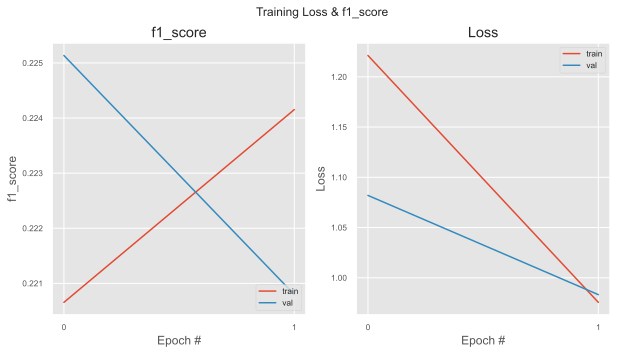

Val Classification Report
              precision    recall  f1-score   support

           0       0.17      0.86      0.28       880
           1       0.82      0.59      0.69      4200
           2       1.00      1.00      1.00       360
           3       0.61      0.40      0.49      6030
           5       0.98      0.87      0.92     14062
           6       0.97      0.99      0.98      5100
           7       0.15      0.89      0.26        87
           8       0.82      0.87      0.84      1148
         101       0.66      0.21      0.32      6000
         102       0.13      0.80      0.23        60
         105       0.70      0.96      0.81      2038
         106       0.75      0.88      0.81      2040
         107       0.23      0.32      0.27      1210
         108       0.21      0.52      0.30      1792

    accuracy                           0.69     45007
   macro avg       0.59      0.73      0.59     45007
weighted avg       0.77      0.69      0.70     45007


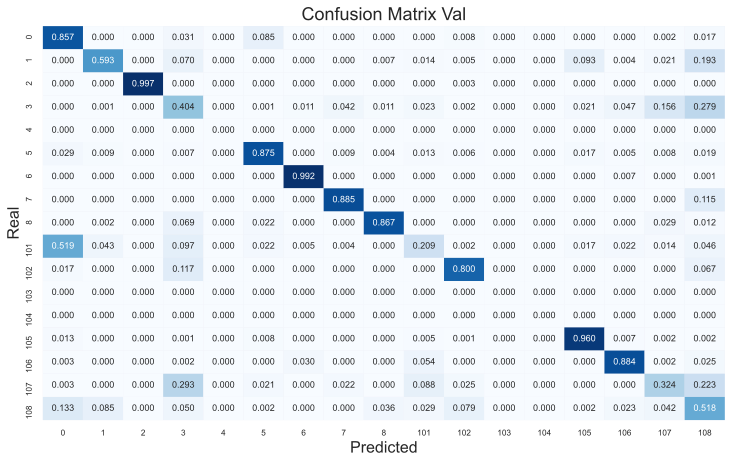

Test Classification Report
              precision    recall  f1-score   support

           0       0.20      0.90      0.32      2424
           1       0.69      0.59      0.64      9129
           2       0.53      0.96      0.68      1080
           3       0.51      0.31      0.38     13674
           5       0.91      0.83      0.87     35281
           6       0.98      0.97      0.97     12867
           7       0.09      0.37      0.14       217
           8       0.81      0.85      0.83      2163
         101       0.62      0.18      0.28     19782
         102       0.06      0.57      0.12       180
         105       0.67      0.95      0.78      5199
         106       0.67      0.92      0.78      5193
         107       0.15      0.24      0.18      3099
         108       0.19      0.45      0.26      4557

    accuracy                           0.63    114845
   macro avg       0.51      0.65      0.52    114845
weighted avg       0.71      0.63      0.63    114845

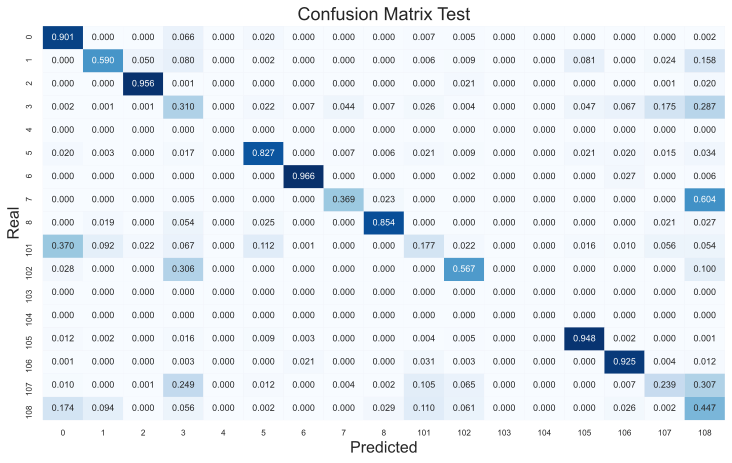

All Data Classification Report
              precision    recall  f1-score   support

           0       0.20      0.76      0.32     14210
           1       0.73      0.60      0.66     48336
           2       0.67      0.97      0.79      5760
           3       0.47      0.34      0.40     68980
           5       0.94      0.85      0.89    176014
           6       0.96      0.96      0.96     64434
           7       0.21      0.88      0.33      1801
           8       0.77      0.86      0.81     10059
         101       0.47      0.15      0.23     86657
         102       0.10      0.59      0.16       960
         105       0.73      0.95      0.82     25926
         106       0.69      0.91      0.78     25866
         107       0.28      0.22      0.25     34072
         108       0.18      0.49      0.26     23961

    accuracy                           0.63    587036
   macro avg       0.53      0.68      0.55    587036
weighted avg       0.68      0.63      0.63    58

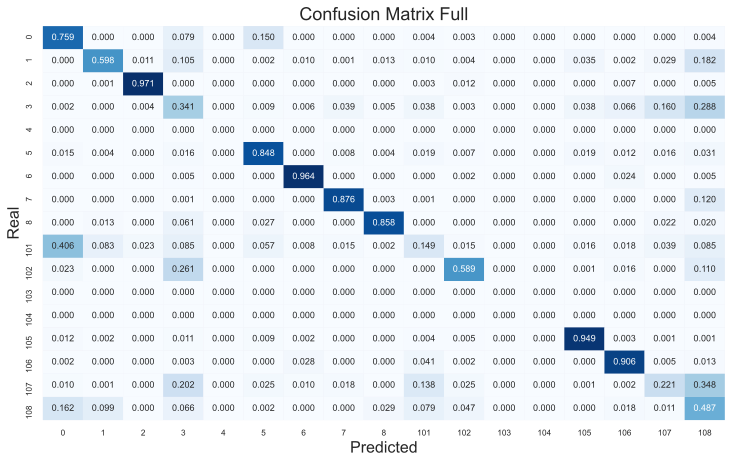

Wall time: 6min 36s


In [201]:
%%time

train_df, test_df, val_df = dset.split(real=False, simul=True, drawn=True, test_size=0.2, val_size=0.1)

linear_layers = [tf.keras.layers.Flatten(),
                 tf.keras.layers.LayerNormalization(),
                 tf.keras.layers.Dense(units=17, activation='sigmoid')]

linear_model = kmodel('LinearModel', linear_layers, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False)

linear_model.compile_and_fit(max_epochs=2, patience=5, lr=0.001)

#linear_model.save()

<table><tr>
<td> 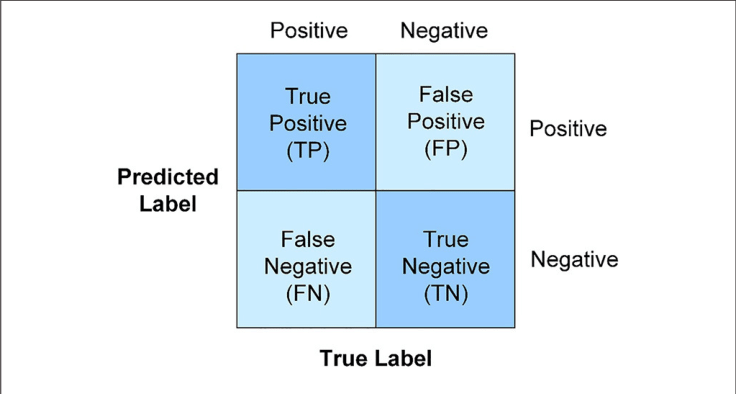 </td>
<td> 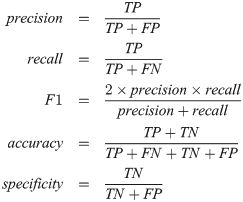 </td>
</tr></table>


# DNN model

In [ ]:
%%time

dnn_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.1, seed=200560),
    tf.keras.layers.Dense(units=17, activation='relu'),
    tf.keras.layers.Softmax()
]
dnn_model = kmodel('DNNModel', dnn_layers, flist0, 'class', categories, 32, 15, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=False)

dnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.0001)

dnn_model.save()

# RNN model

In [ ]:
%%time

train_df, test_df, val_df = dset.split(real=True, simul=True, drawn=True, test_size=0.2, val_size=0.1)

rnn_layers =[
    tf.keras.layers.LSTM(128, return_sequences=False, dropout=0.15),
    tf.keras.layers.Dense(units=17, activation='relu'),
    tf.keras.layers.Softmax()
]

rnn_model = kmodel('RNNModel', rnn_layers, flist0, 'class', categories, 64, 30, 
                      train_df, val_df, test_df, 'D:/datatmp', reset_ts=True, class_bal=True)

rnn_model.compile_and_fit(max_epochs=50, patience=5, lr=0.001)

rnn_model.save()

Instances Train: 1425  Test: 397  Validation: 159
RNNModel input [(None, 30, 16)]
RNNModel lstm_2 (None, 128)
RNNModel dense_8 (None, 17)
RNNModel softmax_2 (None, 17)


Model: "RNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 30, 16)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               74240     
                                                                 
 dense_8 (Dense)             (None, 17)                2193      
                                                                 
 softmax_2 (Softmax)         (None, 17)                0         
                                                                 
Total params: 76,433
Trainable params: 76,433
Non-trainable params: 0
_________________________________________________________________
None


In [187]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11736670467619658784
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1422540800
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1340024160998403260
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 950, pci bus id: 0000:01:00.0, compute capability: 5.2"
xla_global_id: 416903419
]
